# CSE 252B: Computer Vision II, Winter 2019 – Assignment 4
### Instructor: Ben Ochoa
### Due: Wednesday, March 4, 2020, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX.
* You must show your work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* This notebook contains skeleton code, which should not be modified (this is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. If you are uncertain about using a specific package, then please ask the instructional staff whether or not it is allowable.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

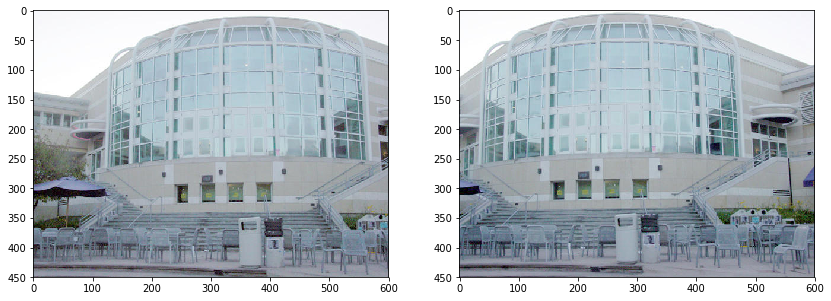

In [13]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

# open the input images
I1 = np.array(Image.open('price_center20.jpeg'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.jpeg'), dtype='float')/255.

# Display the input images
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(I1)
plt.subplot(1,2,2)
plt.imshow(I2)
plt.show()

## Problem 1 (Programming): Feature detection (20 points)
Download input data from the course website. The file price_center20.JPG
contains image 1 and the file price_center21.JPG contains image 2. 

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the x and y direction, respectively. Calculate the gradient images using the fivepoint
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that
around 600–650 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Forstner corner point
operator.

#### Report your final values for:
 * the size of the feature detection window (i.e. the size of the window used to calculate the elements in the gradient matrix N)
 * the minor eigenvalue threshold value 
 * the size of the local nonmaximum suppression window 
 * the resulting number of features detected (i.e. corners) in each image.

#### Display figures for:
 * original images with detected features

A typical implementation takes around <strong>30</strong> seconds to run. If yours takes more than <strong>60</strong> seconds, you may lose points.

In [14]:
from scipy.signal import convolve
def rgb2gray(img):
    return 0.299* img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]

def ImageGradient(I):
    # inputs: 
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    #
    # outputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    
    m, n = I.shape[:2]
    
    """your code here"""
    if len(I.shape) == 3:
        img_gray = rgb2gray(I)
        
    else:
        img_gray = img
        
    #Ix,Iy = np.gradient(img_gray)
    kernel = (1.0/12)*np.array([[-1,8,0,-8,1]]).T 
    Ix = convolve(img_gray, kernel.T, mode='same')
    Iy = convolve(img_gray, kernel, mode='same')
    return Ix, Iy
    
    

def MinorEigenvalueImage(Ix, Iy, w):
    # Calculate the minor eigenvalue image J
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    #
    # outputs:
    # J0 is the mxn minor eigenvalue image of N before thresholding

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))
    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix*Iy
    _w = int(w//2)
    bigN = np.zeros((m,n,2,2))
    bigB = np.zeros((m,n,2,1))
    b1 = np.zeros((m,n))
    b2 = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            b1[i][j] = j * Ixx[i][j] + i * Ixy[i][j]
            b2[i][j] = j * Ixy[i][j] + i * Iyy[i][j]
    
    #Calculate your minor eigenvalue image J0.
    """your code here"""
    for i in range(_w,m-_w):
        for j in range(_w,n-_w):
            N = np.zeros((2,2))
            N[0,0] = np.sum(Ixx[i-_w:i+_w+1,j-_w:j+_w+1]) 
            N[1,1] = np.sum(Iyy[i-_w:i+_w+1,j-_w:j+_w+1]) 
            tmp = np.sum(Ixy[i-_w:i+_w+1,j-_w:j+_w+1])
            N[0,1] = N[1,0] = tmp
            bigN[i,j,:,:] = N
            bigB[i,j,0,0] = np.sum(b1[i-_w:i+_w+1,j-_w:j+_w+1]) 
            bigB[i,j,1,0] = np.sum(b2[i-_w:i+_w+1,j-_w:j+_w+1]) 
            trace = np.matrix.trace(N)
            lambd = (trace - np.sqrt(trace**2 - 4*np.linalg.det(N)))/2
            J0[i,j] = lambd
    return J0,bigN,bigB


  
def NMS(J, w_nms):
    # Apply nonmaximum supression to J using window w_nms
    #
    # inputs: 
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    # 
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    # 
    
    J2 = J.copy()
    """your code here"""
    m,n = J.shape[:2]
    _w = w_nms //2
    for i in range(m):
        for j in range(n):
            up = max(0,i-_w)
            down = min(i+_w,m-1)
            left = max(0,j-_w)
            right = min(j+_w,n-1)
            _max = np.max(J[up:down+1,left:right+1])
            if _max > J[i,j]:
                J2[i,j] = 0
    return J2
  
def ForstnerCornerDetector(Ix, Iy, w, t, w_nms):
    # Calculate the minor eigenvalue image J
    # Threshold J
    # Run non-maxima suppression on the thresholded J
    # Gather the coordinates of the nonzero pixels in J 
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    # w_nms is the size of the local nonmaximum suppression window
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC array of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    # J2 is the mxn minor eigenvalue image of N after thresholding and NMS

    
    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))

    #Calculate your minor eigenvalue image J0 and its thresholded version J1.
    """your code here"""
    J0, bigN, bigB = MinorEigenvalueImage(Ix, Iy, w)
    #print("finished MinorEigenvalueImage")
    J1 = J0.copy()
    J1[J1<t] = 0
    #Run non-maxima suppression on your thresholded minor eigenvalue image.
    J2 = NMS(J1, w_nms)

    #Detect corners.
    """your code here"""
    b1 = np.zeros((m,n))
    b2 = np.zeros((m,n))
    C = 0
    corners = []
    for i in range(m):
        for j in range(n):
            if J2[i,j] > 0:
                C += 1
                corner = np.dot(np.linalg.inv(bigN[i,j,:,:]),bigB[i,j,:,:])
                corners.append(corner)
    pts = np.zeros((2,len(corners)))
    for i in range(len(corners)):
        pts[1,i] = corners[i][0]
        pts[0,i] = corners[i][1]
    print("finished ForstnerCornerDetection")
    return C, pts, J0, J1, J2


# feature detection
def RunFeatureDetection(I, w, t, w_nms):
    Ix, Iy = ImageGradient(I)
    C, pts, J0, J1, J2 = ForstnerCornerDetector(Ix, Iy, w, t, w_nms)
    return C, pts, J0, J1, J2

/Users/tommyhuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in sqrt
/Users/tommyhuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in less


finished ForstnerCornerDetection
finished ForstnerCornerDetection
took 25.673573 secs


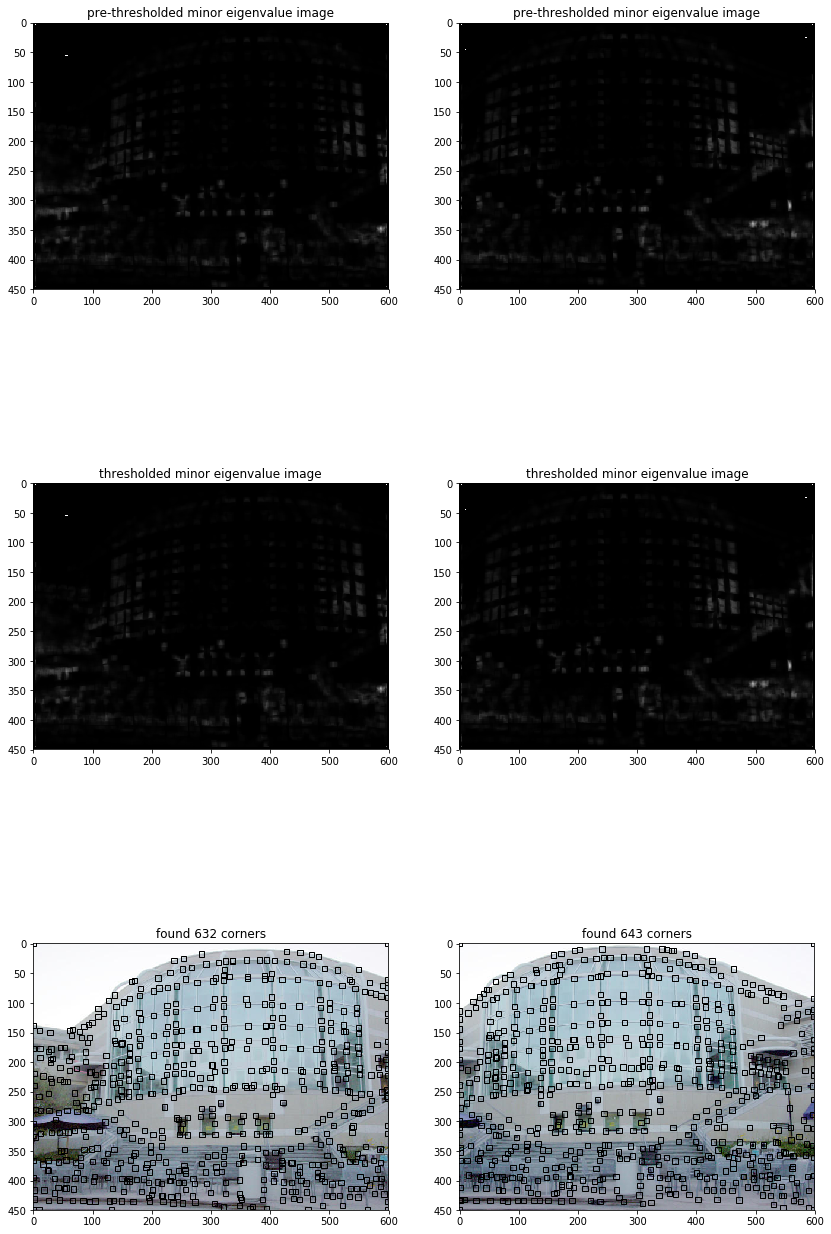

In [15]:
# input images
I1 = np.array(Image.open('price_center20.jpeg'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.jpeg'), dtype='float')/255.

# parameters to tune
#w = 1
#t = 1
#w_nms = 1
w = 9
t = 0.01
w_nms = 9

tic = time.time()
# run feature detection algorithm on input images
C1, pts1, J1_0, J1_1, J1_2 = RunFeatureDetection(I1, w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = RunFeatureDetection(I2, w, t, w_nms)
toc = time.time() - tic

print('took %f secs'%toc)

# display results
plt.figure(figsize=(14,24))

# show pre-thresholded minor eigenvalue images
plt.subplot(3,2,1)
plt.imshow(J1_0, cmap='gray')
plt.title('pre-thresholded minor eigenvalue image')
plt.subplot(3,2,2)
plt.imshow(J2_0, cmap='gray')
plt.title('pre-thresholded minor eigenvalue image')

# show thresholded minor eigenvalue images
plt.subplot(3,2,3)
plt.imshow(J1_1, cmap='gray')
plt.title('thresholded minor eigenvalue image')
plt.subplot(3,2,4)
plt.imshow(J2_1, cmap='gray')
plt.title('thresholded minor eigenvalue image')

# show corners on original images
ax = plt.subplot(3,2,5)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    y,x = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
plt.title('found %d corners'%C1)

ax = plt.subplot(3,2,6)
plt.imshow(I2)
for i in range(C2):
    y,x = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
plt.title('found %d corners'%C2)

plt.show()

#### Final values for parameters
* w = 9
* t = 0.01
* w_nms = 9
* C1 = 632
* C2 = 643

## Problem 2 (Programming): Feature matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that around 200 putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1.

#### Report your final values for:
* the size of the matching window
* the correlation coefficient threshold
* the distance ratio threshold 
* the size of the proximity window (if used)
* the resulting number of putative feature correspondences (i.e. matched features)

#### Display figures for:
* pair of images, where the matched features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image

A typical implementation takes around <strong>10</strong> seconds to run. If yours takes more than <strong>30</strong> seconds, you may lose points.

In [16]:
def NCC(I1, I2, pts1, pts2, w, p):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # p is the size of the proximity window
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in 
    #    image 1 and all windows in image 2
    
    """your code here"""
    C1 = pts1.shape[1]
    C2 = pts2.shape[1]
    I1_gray = rgb2gray(I1)
    I2_gray = rgb2gray(I2)
    m,n = I1_gray.shape
    w = int(w//2)
    scores = np.zeros((C1,C2))
    for c1 in range(C1):
        for c2 in range(C2):
            y1,x1 = int(pts1[:,c1][0]),int(pts1[:,c1][1])
            y2,x2 = int(pts2[:,c2][0]),int(pts2[:,c2][1])
            if y1-w<0 or y1+w>m-1 or x1-w<0 or x1+w>n-1 or y2-w<0 or y2+w>m-1 or x2-w<0 or x2+w>n-1:
                continue
            if np.sqrt((y1-y2)**2+ (x1-x2)**2) > p:
                continue
            patch1 = I1_gray[y1-w:y1+w+1,x1-w:x1+w+1]
            patch2 = I2_gray[y2-w:y2+w+1,x2-w:x2+w+1]
            mean1 = np.mean(patch1)
            mean2 = np.mean(patch2)
            up1 = patch1-mean1
            up2 = patch2-mean2
            down1 = np.sqrt(np.sum(up1**2))
            down2 = np.sqrt(np.sum(up2**2))
            s1 = up1/down1
            s2 = up2/down2
            scores[c1][c2] = np.sum(s1*s2)
            #print(scores[c1][c2] )
    print("NCC finished")
    return scores


def Match(scores, t, d):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    # 
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ration threshold
    #
    # output:
    # 2xM array of the feature coordinates in image 1 and image 2,
    # where M is the number of matches.
    
    """your code here"""
    inds = []
    m,n = scores.shape
    best = np.max(scores)
    i,j = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
    
    mask = np.ones((m,n), dtype = bool)
    while best > t:
        scores[i][j] = -1
        nextbest_row = np.max(scores[i,:])
        nextbest_col = np.max(scores[:,j])
        nextbest = max(nextbest_row,nextbest_col)
        idx = np.where(scores == nextbest)
        next_i = idx[0][0]
        next_j = idx[1][0]
        scores[i][j] = best
        if (1-best) < (1-nextbest) * d:
            inds.append((i,j))
        for ii in range(m):
            mask[ii,j] = False
        for jj in range(n):
            mask[i,jj] = False
        #best = np.max(scores)
        #i,j = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
        #while mask[i][j] == False:
        #    scores[i][j] = -1
        #    best = np.max(scores)
        #    i,j = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
        best = np.max(scores* mask)
        i,j = np.unravel_index(np.argmax(scores* mask, axis=None), scores.shape)

    print("finished Matching")
    return np.array(inds).T

def RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1 
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches
    
    scores = NCC(I1, I2, pts1, pts2, w, p)
    inds = Match(scores, t, d)
    return inds

NCC finished
finished Matching
took 6.626272 secs


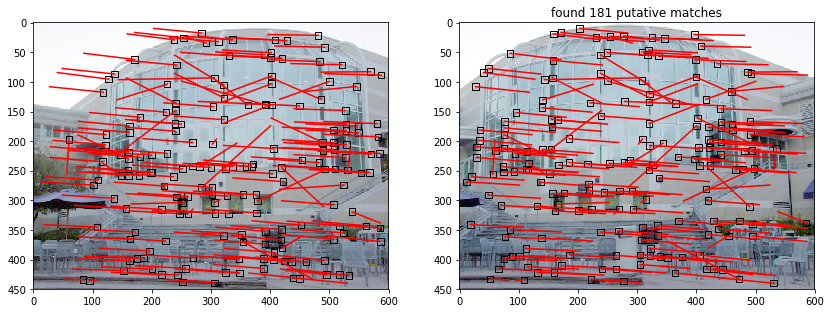

unique points in image 1: 181
unique points in image 2: 181


In [17]:
# parameters to tune

w = 11
t = 0.8
d = 0.9
p = 170

tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features 
match1 = pts1[:,inds[0,:].astype('int')]
match2 = pts2[:,inds[1,:].astype('int')]

# display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d putative matches'%match1.shape[1])
for i in range(match1.shape[1]):
    y1,x1 = match1[:,i]
    y2,x2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

# test 1-1
print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

#### Final values for parameters
* w = 11
* t = 0.8 
* d = 0.9
* p = 170
* num_matches = 181

## Problem 3 (Programming): Outlier Rejection (15 points)
The resulting set of putative point correspondences should contain both inlier
and outlier correspondences (i.e., false matches). Determine the set of inlier point
correspondences using the M-estimator Sample Consensus (MSAC) algorithm,
where the maximum number of attempts to find a consensus set is determined
adaptively. For each trial, you must use the 4-point algorithm (as described in
lecture) to estimate the planar projective transformation from the 2D points in
image 1 to the 2D points in image 2. Calculate the (squared) Sampson error as a
first order approximation to the geometric error.

hint: this problem has codimension 2

#### Report your values for:
 * the probability $p$ that as least one of the random samples does not contain any outliers
 * the probability $\alpha$ that a given point is an inlier
 * the resulting number of inliers
 * the number of attempts to find the consensus set
 * the tolerance for inliers
 * the cost threshold
 
#### Display figures for:
* pair of images, where the inlier features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image


tol:7, thresh:5.991464547107979, alpha:0.95, p:0.99
took 0.028130 secs
12 iterations
inlier count:  126
inliers:  [1, 2, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 79, 80, 81, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 115, 116, 117, 118, 122, 123, 124, 127, 128, 131, 132, 133, 135, 136, 137, 138, 139, 142, 144, 145, 146, 148, 149, 153, 154, 157, 158, 163, 166, 175, 176, 177, 178, 179]
MSAC Cost=574.488293399
H_MSAC =
[[ 1.08820075e-02  2.60099780e-04 -1.45451272e-01]
 [-5.38002168e-05  1.11832976e-02 -9.89186217e-01]
 [-7.40246830e-09  1.07516687e-06  1.05356967e-02]]


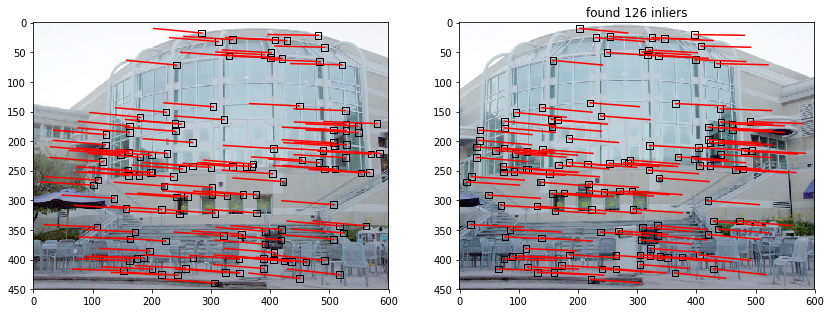

In [18]:
from scipy.stats import chi2
import random
def DisplayResults(H, title):
    print(title+' =')
    print (H/np.linalg.norm(H)*np.sign(H[-1,-1]))

def Homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))

def Dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1]/x[-1]

def MSAC(pts1, pts2, thresh, tol, p):
    # Inputs:
    #    pts1 - matched feature correspondences in image 1
    #    pts2 - matched feature correspondences in image 2
    #    thresh - cost threshold
    #    tol - reprojection error tolerance 
    #    p - probability that as least one of the random samples does not contain any outliers   
    #
    # Output:
    #    consensus_min_cost - final cost from MSAC
    #    consensus_min_cost_model - planar projective transformation matrix H
    #    inliers - list of indices of the inliers corresponding to input data
    #    trials - number of attempts taken to find consensus set
    
    """your code here"""
    
    trials = 0
    max_trials = np.inf
    consensus_min_cost = np.inf
    consensus_min_cost_model = np.zeros((3,4))
    inliers = np.random.randint(0, 200, size=100)
    N = match1.shape[1] # N = 203 here
    s = 3
    deltaX_final = []
    bigJ_final = []
    while trials < max_trials and consensus_min_cost > thresh:
        rand_idx = random.sample(range(N),4)
        x = pts1[:,rand_idx]
        x_p = pts2[:,rand_idx]
        x_homo = Homogenize(x)
        x_p_homo =  Homogenize(x_p)
        x1,x2,x3,x4 = x_homo [:,0:1], x_homo [:,1:2], x_homo [:,2:3], x_homo [:,3:4]
        x1_p,x2_p,x3_p,x4_p = x_p_homo[:,0:1], x_p_homo[:,1:2], x_p_homo[:,2:3], x_p_homo[:,3:4]
        e = np.hstack((x1, np.hstack((x2, x3))))
        e_p = np.hstack((x1_p, np.hstack((x2_p, x3_p))))
        lambdaX = np.dot(np.linalg.inv(e),x4)
        lambdaX_p = np.dot(np.linalg.inv(e_p),x4_p)
        H1_inv = np.hstack((lambdaX[0,0]* x1, np.hstack((lambdaX[1,0]* x2, lambdaX[2,0]* x3))))
        H2_inv = np.hstack((lambdaX_p[0,0]* x1_p, np.hstack((lambdaX_p[1,0]* x2_p, lambdaX_p[2,0]* x3_p))))

        H12 = np.dot(H2_inv,np.linalg.inv(H1_inv))

        sampson_error = np.zeros(N)
        deltaX = []
        bigJ = []
        for i in range(N):
            xx = pts1[:,i]
            xx_p = pts2[:,i]
            Ah = np.zeros((2,1))
            Ah[0,0] = -(xx[0]*H12[1,0] + xx[1]*H12[1,1] + H12[1,2]) + xx_p[1]*(xx[0]*H12[2,0]+xx[1]*H12[2,1] + H12[2,2])
            Ah[1,0] = (xx[0]*H12[0,0] + xx[1]*H12[0,1] + H12[0,2]) - xx_p[0]*(xx[0]*H12[2,0]+xx[1]*H12[2,1] + H12[2,2])

            J = np.zeros((2,4))
            J[0,0] = -H12[1,0] + xx_p[1]*H12[2,0]
            J[0,1] = -H12[1,1] + xx_p[1]*H12[2,1]
            J[0,3] = xx[0]*H12[2,0] + xx[1]*H12[2,1] + H12[2,2]
            J[1,0] = H12[0,0] - xx_p[0]*H12[2,0] 
            J[1,1] = H12[0,1] - xx_p[0]*H12[2,1] 
            J[1,2] = -(xx[0]*H12[2,0] + xx[1]*H12[2,1] + H12[2,2])
            error = np.dot(Ah.T, np.dot(np.dot(J, J.T), Ah))
            sampson_error[i] = error  
        #print("len of deltaX:{}".format(len(deltaX)))
        cost = 0
        cur_inliers = []
        
        for i in range(N):
            if sampson_error[i] <= tol:
                cost += sampson_error[i]
                cur_inliers.append(i)
            else:
                cost += tol
        
        #print("trials:{:3d}, cost:{:.3f}, cost_min:{:.3f}, #inliers:{:4d} ".format(trials, cost, consensus_min_cost, len(cur_inliers)))
        
        if cost < consensus_min_cost:
            consensus_min_cost = cost
            consensus_min_cost_model = H12
            len_inlier = len(cur_inliers)
            w = len_inlier / N
            max_trials = np.log(1-p)/np.log(1-w**s)
            inliers = cur_inliers
            deltaX_final = deltaX
            bigJ_final = bigJ
            
        trials += 1
    deltaX_final = np.array(deltaX_final).T
    return consensus_min_cost, consensus_min_cost_model, inliers, trials


# MSAC parameters 

from scipy.stats import chi2

tol = 7
p = 0.99
alpha = 0.95
variance = 1
thresh = chi2.ppf(alpha, df=2) * variance**2

print("tol:{}, thresh:{}, alpha:{}, p:{}".format(tol, thresh, alpha, p))
tic=time.time()

cost_MSAC, H_MSAC, inliers, trials = MSAC(match1, match2, thresh, tol, p)

# choose just the inliers
#xin1 = pts1[:,inliers]
#xin2 = pts2[:,inliers]

xin1 = match1[:,inliers]
xin2 = match2[:,inliers]
toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('%d iterations'%trials)
print('inlier count: ',len(inliers))
print('inliers: ',inliers)
print('MSAC Cost=%.9f'%cost_MSAC)
DisplayResults(H_MSAC, 'H_MSAC')

# display the figures
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d inliers'%xin1.shape[1])
for i in range(xin1.shape[1]):
    y1,x1 = xin1[:,i]
    y2,x2 = xin2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

#### Final values for parameters
* $p$ = 0.99
* $\alpha$ = 0.95
* tolerance = 5
* threshold = 5.99
* num_inliers = 122
* num_attempts = 24

## Problem 4 (Programming): Linear Estimate (15 points)
  Estimate the planar projective transformation $\boldsymbol{H}_\text{DLT}$
  from the resulting set of inlier correspondences using the direct
  linear transformation (DLT) algorithm (with data normalization).
  You must express $\boldsymbol{x}'_i = \boldsymbol{H} \boldsymbol{x}_i$ as
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$ (not
  $\boldsymbol{x}'_i \times \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$), where
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{x}'_i = \boldsymbol{0}$, when forming the
  solution. Return $\boldsymbol{H}_\text{DLT}$, scaled such that
  $||\boldsymbol{H}_\text{DLT}||_\text{Fro} = 1$

In [39]:
import math
def Homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))

def Dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1]/x[-1]

def Normalize(pts):
    # data normalization of n dimensional pts #
    # Input:
    # pts - is in inhomogeneous coordinates # Outputs:
        #    pts - data normalized points
    # T - corresponding transformation matrix """your code here"""
    T = np.eye(pts.shape[0]+1) 
    if pts.shape[0] == 2:
        means = np.mean(pts, axis = 1) 
        _vars = np.var(pts, axis = 1) 
        var = np.sum(_vars)
        scale = math.sqrt(2/var) 
        T[0,0] = scale
        T[1,1] = scale
        T[0,2] = -means[0] * scale 
        T[1,2] = -means[1] * scale
    
    if pts.shape[0] == 3:
        means= np.mean(pts, axis = 1) 
        _vars= np.var(pts, axis = 1) 
        var = np.sum(_vars)
        scale = math.sqrt(3/var) 
        T[0,0] = scale
        T[1,1] = scale
        T[2,2] = scale
        T[0,3] = -means[0] * scale 
        T[1,3] = -means[1] * scale 
        T[2,3] = -means[2] * scale
    pts = np.dot(T, Homogenize(pts)) 
    return pts, T

def leftnull(sub_x):
    sub_x = np.reshape(sub_x,(sub_x.size,1))
    u, _, _ = np.linalg.svd(sub_x,full_matrices=True) 
    _leftnull = u[:,1:].T
    return _leftnull

def ComputeCost_DLT(H12, x1, x2,T1,T2,normalize = True):
    # Inputs:
    #    x - 2D inhomogeneous image points
    #    X - 3D inhomogeneous scene points
    #
    # Output:
    #    cost - Total reprojection error

    #print("H_DLT in computeCost:{}".format(H_DLT))
    n = x1.shape[1] 
    sigmax1 = float(T1[0][0]**2)* np.eye(2)
    sigmax2 = float(T2[0][0]**2)* np.eye(2)
    """your code here"""
    uncorrected_points = np.vstack((x1,x2))
    cost = 0
    for i in range(n):
        Ah = np.zeros((2,1))
        J = np.zeros((2,4))
        xx = x1[:,i]
        xx_p = x2[:,i]
        xx1,yy1 = xx[0], xx[1]
        xx2,yy2 = xx_p[0], xx_p[1]
        Ah[0,0] = -(xx[0]*H12[1,0] + xx[1]*H12[1,1] + H12[1,2]) + xx_p[1]*(xx[0]*H12[2,0]+xx[1]*H12[2,1] + H12[2,2])
        Ah[1,0] = (xx[0]*H12[0,0] + xx[1]*H12[0,1] + H12[0,2]) - xx_p[0]*(xx[0]*H12[2,0]+xx[1]*H12[2,1] + H12[2,2])
        J[0,0] = -H12[1,0] + xx_p[1]*H12[2,0]
        J[0,1] = -H12[1,1] + xx_p[1]*H12[2,1]
        J[0,3] = xx[0]*H12[2,0] + xx[1]*H12[2,1] + H12[2,2]
        J[1,0] = H12[0,0] - xx_p[0]*H12[2,0] 
        J[1,1] = H12[0,1] - xx_p[0]*H12[2,1] 
        J[1,2] = -(xx[0]*H12[2,0] + xx[1]*H12[2,1] + H12[2,2])
        lamb = -np.dot(np.linalg.inv(np.dot(J, J.T)),Ah)
        _deltaX = np.dot(J.T, lamb)
        epslon1 = np.array([_deltaX[0],_deltaX[1]])
        xx = np.array([[xx[0]],[xx[1]]])
        xx_p = np.array([[xx_p[0]],[xx_p[1]]])
        x_scene = xx + _deltaX[:2,:]
        epslon2 = xx_p - Dehomogenize(np.dot(H12,Homogenize(x_scene)))
        cost1 = epslon1.T@np.linalg.inv(sigmax1)@epslon1
        cost2 = epslon2.T@np.linalg.inv(sigmax2)@epslon2
       
        cost += (cost1[0][0] + cost2[0][0])
    return cost

def DLT(x1, x2,normalize=True):
    # Inputs:
    #    x1 - inhomogeneous inlier correspondences in image 1
    #    x2 - inhomogeneous inlier correspondences in image 1
    #    normalize - if True, apply data normalization to x1 and x2
    #
    # Outputs:
    #    H - the DLT estimate of the planar projective transformation   
    #    cost - linear estimate cost
    
    """your code here"""
    n = x1.shape[1]
    d = x1.shape[0]
    # data normalization

    if normalize:
        print('normalize')
        x1, T1 = Normalize(x1)
        x2, T2 = Normalize(x2)

    # data denormalize
    else:
        print('denormalize')
        T1 = np.eye(3)
        T2 = np.eye(3)
        x1 = Homogenize(x1)
        x2 = Homogenize(x2)
    A = np.zeros((2*n,9))
    for i in range(n):
        _leftnull = leftnull(x2[:,i:i+1])
        sub_A = np.kron(_leftnull,x1[:,i:i+1].T) 
        A[2*i:2*i+2,:] = sub_A
        
    u, s, vh = np.linalg.svd(A)
    H_flatten = vh[8:,:]
    H = H_flatten.reshape((3,3))
    #print("H:{}".format(H))
    cost = ComputeCost_DLT(H, Dehomogenize(x1), Dehomogenize(x2),T1,T2,normalize)
    return H, cost

xin1 = match1[:,inliers]
xin2 = match2[:,inliers]
print ('Running DLT without data normalization')
time_start=time.time()
H_DLT,cost = DLT(xin1, xin2, normalize=False)
DisplayResults(H_DLT, 'H_DLT')
time_total=time.time()-time_start
# display the results
print('took %f secs'%time_total)
print('Cost=%.9f'%cost)

# compute the linear estimate with data normalization
print ('Running DLT with data normalization')
time_start=time.time()
H_DLT,cost = DLT(xin1, xin2, normalize=True)
DisplayResults(H_DLT, 'H_DLT')
time_total=time.time()-time_start
# display the results
print('took %f secs'%time_total)
print('Cost=%.9f'%cost)

Running DLT without data normalization
denormalize
H_DLT =
[[ 1.07435064e-02  3.06338346e-04 -1.67420221e-01]
 [-1.86716279e-05  1.10297842e-02 -9.85711280e-01]
 [ 7.75437473e-08  1.17833871e-06  1.03231802e-02]]
H_DLT: [[-1.07435064e-02 -3.06338346e-04  1.67420221e-01]
 [ 1.86716279e-05 -1.10297842e-02  9.85711280e-01]
 [-7.75437473e-08 -1.17833871e-06 -1.03231802e-02]]
took 0.021984 secs
Cost=20.450137644
Running DLT with data normalization
normalize
H_DLT =
[[ 5.77580561e-01  3.11807500e-04 -9.63826633e-04]
 [-2.43712803e-03  5.77354459e-01  9.81565929e-03]
 [ 2.44471125e-04  8.21163349e-03  5.76967694e-01]]
took 0.022539 secs
Cost=19.486026230


In [37]:
# display your H_DLT, scaled with its frobenius norm
DisplayResults(H_DLT, 'H_DLT')


H_DLT =
[[ 5.77580561e-01  3.11807500e-04 -9.63826633e-04]
 [-2.43712803e-03  5.77354459e-01  9.81565929e-03]
 [ 2.44471125e-04  8.21163349e-03  5.76967694e-01]]


## Problem 5 (Programming): Nonlinear Estimate (45 points) 
 Use $\boldsymbol{H}_\text{DLT}$ and the Sampson corrected points (in image 1) as an initial estimate to an iterative estimation method,
  specifically the sparse Levenberg-Marquardt algorithm, to
  determine the Maximum Likelihood estimate of the planar projective
  transformation that minimizes the reprojection error.  You must
  parameterize the planar projective transformation matrix and the
  homogeneous 2D scene points that are being adjusted using the
  parameterization of homogeneous vectors (see section A6.9.2 (page 624) of the textbook, and the corrections and errata).
  
  Report the initial cost (i.e. cost at iteration 0) and the cost at the end
  of each successive iteration. Show the numerical values for the final 
  estimate of the planar projective transformation matrix $\boldsymbol{H}_\text{LM}$, scaled
  such that $||\boldsymbol{H}_\text{LM}||_\text{Fro} = 1$.

In [21]:
import math
def Sinc(x):
    """your code here"""
    if x == 0:
        return 1
    else:
        return math.sin(x)/x
    
def dSinc(x):
    if x == 0:
        return 0
    return (math.cos(x)/x) - (math.sin(x)/(x**2))

def Parameterize(P):
    # takes all optimization variables and parameterizes all of them
    # in this case it is just P, but in future assignments it will
    # be more useful
    return ParameterizeHomog(P.reshape(-1,1))

def Deparameterize(p):
    # Deparameterize all optimization variables 
    return DeParameterizeHomog(p).reshape(3,3)

def ParameterizeHomog(V):
    # Given a homogeneous vector V return its minimal parameterization 
    """your code here"""
    v = V / np.linalg.norm(V)
    a = v[0][0]
    b = v[1:,:]
    v_hat = 2/(Sinc(math.acos(a)))*b
    v_norm = np.linalg.norm(v_hat)
    if v_norm > math.pi:
        scale = 1-(2*math.pi/v_norm)*math.ceil((v_norm - math.pi)/(2*math.pi))
        v_hat = scale * v_hat 
    return v_hat

def DeParameterizeHomog(v):
    # Given a parameterized homogeneous vector return its deparameterizatio """your code here"""
    v_norm = np.linalg.norm(v)
    a = math.cos(v_norm/2)
    b = Sinc(v_norm /2 )*0.5 * v.T
    v_bar = np.zeros((v.shape[0]+1,1))
    v_bar[0,0] = a
    v_bar[1:v.shape[0]+1,:] = b.T
    v_bar = v_bar/ np.linalg.norm(v_bar)
    return v_bar

def dvbar_dv(v, v_bar):
    '''
    v is parameterized vector
    v_bar is deparametereized vector
    '''
    v_norm = np.linalg.norm(v)
    a = v_bar[0,0]
    b = v_bar[1:,:]
    n = b.shape[0]
    if v_norm == 1:
        av = np.zeros((1,n))
        bv = 0.5 *np.eye(n)
    else: 
        av = -0.5 * b.T
        _dsinc = dSinc(v_norm/ 2)
        bv = 0.5*Sinc(v_norm/2)*np.eye(n) + 1/(4*v_norm) * _dsinc * np.dot(v, v.T)
    _dvbar_dv = np.vstack((av,bv))
    return _dvbar_dv
    
def getA(H,x_scene_hat):
    x2_p_hat_homo = Dehomogenize(np.dot(H,x_scene_hat))
    h = Parameterize(H)
    w_p = np.dot(H[2:3,:], x_scene_hat)[0][0]
    dxbar_dh = np.zeros((2,9))
    dxbar_dh[0:1, :3] = x_scene_hat.T
    dxbar_dh[1:2, 3:6] = x_scene_hat.T
    dxbar_dh[0:1, 6:] = -x2_p_hat_homo[0][0]* x_scene_hat.T
    dxbar_dh[1:2, 6:] = -x2_p_hat_homo[1][0]* x_scene_hat.T
    dxbar_dh = (1/w_p) * dxbar_dh
    h_bar = DeParameterizeHomog(h)
    
    dhbar_dh = dvbar_dv(h, h_bar)
    return np.dot(dxbar_dh,dhbar_dh)

def getB(H, x_scene):
    dx_dxs = np.zeros((2,3))
    w_p = np.dot(H[2:3,:], x_scene)[0][0]
    
    dx_dxs[0:1,:] = H[0:1,:] - Dehomogenize(x_scene)[0][0] * H[2:3,:]
    dx_dxs[1:2,:] = H[1:2,:] - Dehomogenize(x_scene)[1][0] * H[2:3,:]
    
    dx_dxs = (1/w_p) * dx_dxs
    
    x_scene_hat = Parameterize(x_scene)
    x_scene_bar = DeParameterizeHomog(x_scene_hat)
    dxsbar_dxs = dvbar_dv(x_scene_hat, x_scene_bar)
    return np.dot(dx_dxs,dxsbar_dxs)

def ComputeCost_LM(h, x1, x2,T1, T2, x_scene):
    
    H = Deparameterize(h)
    n = x1.shape[1] 
    sigmax1 = float(T1[0][0]**2)* np.eye(2)
    sigmax2 = float(T2[0][0]**2)* np.eye(2)
    """your code here"""
    cost = 0
    for i in range(n):
        Ah = np.zeros((2,1))
        J = np.zeros((2,4))
        xx1 = Dehomogenize(x1[:,i:i+1])
        xx2 = Dehomogenize(x2[:,i:i+1])
        
        epslon1 = xx1 - Dehomogenize(x_scene[:,i:i+1])
        x_scene_ele = x_scene[:,i:i+1]
        epslon2 = xx2 - Dehomogenize(np.dot(H,x_scene_ele))
        cost1 = epslon1.T@np.linalg.inv(sigmax1)@epslon1
        cost2 = epslon2.T@np.linalg.inv(sigmax2)@epslon2
        cost += (cost1[0][0] + cost2[0][0])
    return cost

In [44]:
from scipy.linalg import block_diag

def getScene(x1, x2, H12):
    #x1, x2 dehomogenized points
    n = x1.shape[1] 
    x_scene = np.zeros((2,n))
    for i in range(n):
        Ah = np.zeros((2,1))
        J = np.zeros((2,4))
        xx = x1[:,i]
        xx_p = x2[:,i]
        xx1,yy1 = xx[0], xx[1]
        xx2,yy2 = xx_p[0], xx_p[1]
        Ah[0,0] = -(xx[0]*H12[1,0] + xx[1]*H12[1,1] + H12[1,2]) + xx_p[1]*(xx[0]*H12[2,0]+xx[1]*H12[2,1] + H12[2,2])
        Ah[1,0] = (xx[0]*H12[0,0] + xx[1]*H12[0,1] + H12[0,2]) - xx_p[0]*(xx[0]*H12[2,0]+xx[1]*H12[2,1] + H12[2,2])
        J[0,0] = -H12[1,0] + xx_p[1]*H12[2,0]
        J[0,1] = -H12[1,1] + xx_p[1]*H12[2,1]
        J[0,3] = xx[0]*H12[2,0] + xx[1]*H12[2,1] + H12[2,2]
        J[1,0] = H12[0,0] - xx_p[0]*H12[2,0] 
        J[1,1] = H12[0,1] - xx_p[0]*H12[2,1] 
        J[1,2] = -(xx[0]*H12[2,0] + xx[1]*H12[2,1] + H12[2,2])
        lamb = -np.dot(np.linalg.inv(np.dot(J, J.T)),Ah)
        _deltaX = np.dot(J.T, lamb)
        
        x_scene[:,i:i+1] = _deltaX[:2,:]
    return x_scene


def LM(H, x1, x2, max_iters, lam):
    # Input:
    #    H - DLT estimate of planar projective transformation matrix
    #    x1 - inhomogeneous inlier points in image 1
    #    x2 - inhomogeneous inlier points in image 2
    #    max_iters - maximum number of iterations
    #    lam - lambda parameter
    # Output:
    #    H - Final H (3x3) obtained after convergence
    # data normalization
   
    """your code here"""
    N = x1.shape[1]
    x1, T1 = Normalize(x1)
    x2, T2 = Normalize(x2)
    sigmax = T1[0,0]**2 * np.eye(2)
    sigmax_p = T2[0,0]**2 * np.eye(2)
    cost = ComputeCost_DLT(H, x1, x2,T1,T2)
    x_scene = getScene(Dehomogenize(x1), Dehomogenize(x2), H)
    x_scene = Homogenize(x_scene)
    h = Parameterize(H)
    H1 = np.eye(3)
    _iter = 0
    minCost = ComputeCost_DLT(H, x1, x2,T1,T2)
    x_scene_hat = np.zeros((2*N,1))
    while _iter < max_iters: 
        #h = Parameterize(H)
        A_p = np.zeros((2*N, 8))
        B = np.zeros((2*N, 2))
        B_p = np.zeros((2*N, 2))
        U_p = np.zeros((8, 8))
        V = np.zeros((2*N, 2))
        B = np.zeros((2*N, 2))
        B_p = np.zeros((2*N, 2))
        W_p = np.zeros((8, 2*N))
        epslon_a = np.zeros((8,1))
        epslon_b = np.zeros((2,N))
        s_minus = np.zeros((8,8))
        epslon_minus = np.zeros((8,1))
        
        #H = Deparameterize(h)
        for i in range(N):
            
            x_scene_ele = x_scene[:,i:i+1]
            x_scene_hat[2*i:2*i+2,:] = Parameterize(x_scene_ele)
            Ai_p = getA(H,x_scene_ele)
            A_p[2*i:2*i+2,:] = Ai_p
            Bi = getB(np.eye(3), x_scene_ele)
            B[2*i:2*i+2,:] = Bi
            Bi_p = getB(H,H@x_scene_ele)
            B_p[2*i:2*i+2,:] = Bi_p
            U_p += Ai_p.T@np.linalg.inv(sigmax_p)@Ai_p
            Vi = Bi.T@np.linalg.inv(sigmax)@Bi + Bi_p.T@np.linalg.inv(sigmax_p)@Bi_p
            V[2*i:2*i+2,:] = Vi
            Wi_p = Ai_p.T @np.linalg.inv(sigmax_p) @ Bi_p
            W_p[:,2*i:2*i+2] = Wi_p
            epslon = Dehomogenize(x1[:,i:i+1]) -  Dehomogenize(x_scene_ele)
            epslon_p = (Dehomogenize(x2[:,i:i+1]) -  Dehomogenize(H@x_scene_ele))
            epslon_a += Ai_p.T @ np.linalg.inv(sigmax_p) @ epslon_p
            epslon_bi = Bi.T@np.linalg.inv(sigmax)@epslon + Bi_p.T@np.linalg.inv(sigmax_p)@epslon_p
            epslon_b[:,i:i+1] = epslon_bi
            s_minus += Wi_p @ np.linalg.inv(Vi+lam * np.eye(2))@Wi_p.T
            epslon_minus += Wi_p @ np.linalg.inv(Vi+lam * np.eye(2)) @ epslon_bi

        s_p = U_p + lam * np.eye(8) + s_minus
        e_p = epslon_a - epslon_minus
        delta_a = np.linalg.inv(s_p) @ e_p
        # Adjust h
        h0 = h + delta_a
        x_scene0 = np.zeros((2,N))

        # Adjust x_scene
        for i in range(N):
            Vi = V[2*i:2*i+2,:]
            epslon_bi = epslon_b[:,i:i+1]
            Wi_p = W_p[:,2*i:2*i+2]
            delta_bi =  np.linalg.pinv(Vi)@(epslon_bi - Wi_p.T@delta_a)
            #print("delta_bi.shape:{}".format(delta_bi.shape))
            x_scene0[:,i:i+1] += delta_bi 
            

        cost0 = ComputeCost_DLT(Deparameterize(h0), x1, x2,T1,T2)
        if cost0 > minCost:
            lam *= 10
            
        elif cost0 < minCost and abs(cost0 - minCost) > 10**(-12):
            minCost = cost0
            h = h0
            H = Deparameterize(h)
            x_scene = Homogenize(x_scene0)
            lam = 0.1*lam
            _iter += 1
            print ('iter %03d Cost %.9f'%(_iter, cost0))
        else:
            _iter += 1
            print ('iter %03d Cost %.9f'%(_iter, cost0))
        #_iter += 1
    # data denormalization
    H = Deparameterize(h)
    #H = np.linalg.inv(T2)@H@T1
    return H

# LM hyperparameters
lam = .001
max_iters = 100
#xin1 = match1[:,inliers]
#xin2 = match2[:,inliers]
#xin1=np.loadtxt('hw4_pts1.txt').T
#xin2=np.loadtxt('hw4_pts2.txt').T
#detaX_inliers = deltaX[:,inliers]
# Run LM initialized by DLT estimate with data normalization
print ('Running sparse LM with data normalization')
print ('iter %03d Cost %.9f'%(0, cost))
time_start=time.time()

H_LM = LM(H_DLT, xin1, xin2, max_iters, lam)
time_total=time.time()-time_start
print('took %f secs'%time_total)

Running sparse LM with data normalization
iter 000 Cost 19.486026230
iter 001 Cost 19.486009810
iter 002 Cost 19.460528104
iter 003 Cost 19.460528104
iter 004 Cost 19.460528104
iter 005 Cost 19.460528104
iter 006 Cost 19.460528104
iter 007 Cost 19.460528104
iter 008 Cost 19.460528104
iter 009 Cost 19.460528104
iter 010 Cost 19.460528104
iter 011 Cost 19.460528104
iter 012 Cost 19.460528104
iter 013 Cost 19.460528104
iter 014 Cost 19.460528104
iter 015 Cost 19.460528104
iter 016 Cost 19.460528104
iter 017 Cost 19.460528104
iter 018 Cost 19.460528104
iter 019 Cost 19.460528104
iter 020 Cost 19.460528104
iter 021 Cost 19.460528104
iter 022 Cost 19.460528104
iter 023 Cost 19.460528104
iter 024 Cost 19.460528104
iter 025 Cost 19.460528104
iter 026 Cost 19.460528104
iter 027 Cost 19.460528104
iter 028 Cost 19.460528104
iter 029 Cost 19.460528104
iter 030 Cost 19.460528104
iter 031 Cost 19.460528104
iter 032 Cost 19.460528104
iter 033 Cost 19.460528104
iter 034 Cost 19.460528104
iter 035 Cost

In [42]:
# display your converged H_LM, scaled with its frobenius norm
DisplayResults(H_LM, 'H_LM')


H_LM =
[[ 5.77530978e-01  3.16731316e-04 -9.63636698e-04]
 [-2.41964983e-03  5.77354427e-01  9.81472538e-03]
 [ 2.48309415e-04  8.20681055e-03  5.77017513e-01]]


In [41]:
import pickle
with open('hw4_lm.pickle', 'rb') as f:
    d = pickle.load(f)
print(d.keys())

dict_keys(['B', "w'", "v'*", "B'", "s'", "e'", "U'*", "A'"])
